<a href="https://colab.research.google.com/github/smeadows2/AI_Class/blob/main/Module_3_Assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

%load_ext tensorboard

# Common imports
import numpy as np
import pandas as pd
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

!pip install keras-tuner
import keras_tuner as kt

def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

from functools import partial
import pathlib

In [ ]:
#!rm -rf cats_and_dogs_filtered

In [ ]:
import zipfile
data_dir = tf.keras.utils.get_file(origin="https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip", 
                                   fname='/content/cats_and_dogs_filtered.zip', 
                                   extract=True)

with zipfile.ZipFile(data_dir,"r") as zip_ref:
    zip_ref.extractall("/content")


In [ ]:
data_dir = pathlib.Path("/content/cats_and_dogs_filtered/train/cats")
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

import os, os.path
# simple version for working with CWD
print(len([name for name in os.listdir('/content/cats_and_dogs_filtered/train/cats/') if os.path.isfile(name)]))

0
0


In [ ]:
batch_size = 32
img_height = 224
img_width = 224

train = tf.keras.preprocessing.image_dataset_from_directory(
  "/content/cats_and_dogs_filtered/train",
  label_mode="int",
  #validation_split=0.2,
  #subset="training",
  seed=42,
  image_size=(img_height, img_width))

validation = tf.keras.preprocessing.image_dataset_from_directory(
  "/content/cats_and_dogs_filtered/validation",
  #validation_split=0.2,
  #subset="validation",
  seed=42,
  image_size=(img_height, img_width))

#class_names = train.features["label"].names
train_class_names = train.class_names
validation_class_names = validation.class_names
print(train_class_names)
display(train, validation)
display(tf.data.experimental.cardinality(train).numpy())
display(tf.data.experimental.cardinality(validation).numpy())

#mean = train.mean(axis=0, keepdims=True)
#std = train.std(axis=0, keepdims=True) + 1e-7
#train = (train - mean) / std
#validation = (validation - mean) / std

data = train.concatenate(validation)
display(data)
display(tf.data.experimental.cardinality(data).numpy())

train_size = int(0.8 * 95)
display(train_size)

data = data.shuffle(buffer_size=100)
train = data.take(76)
validation = data.skip(76)
display(train, validation)
display(tf.data.experimental.cardinality(train).numpy())
display(tf.data.experimental.cardinality(validation).numpy())

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
['cats', 'dogs']


<BatchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>

<BatchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>

63

32

<ConcatenateDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>

95

76

<TakeDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>

<SkipDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>

76

19

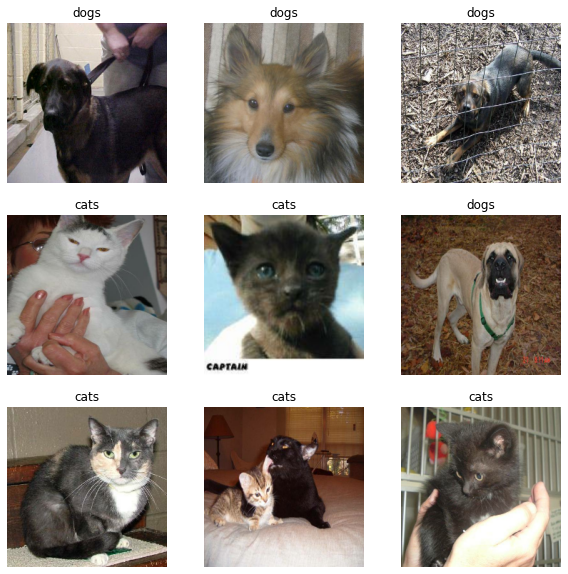

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    #plt.imshow(images[i] / 2 + 0.5)
    #plt.imshow(images[i])
    plt.title(train_class_names[labels[i]])
    plt.axis("off")

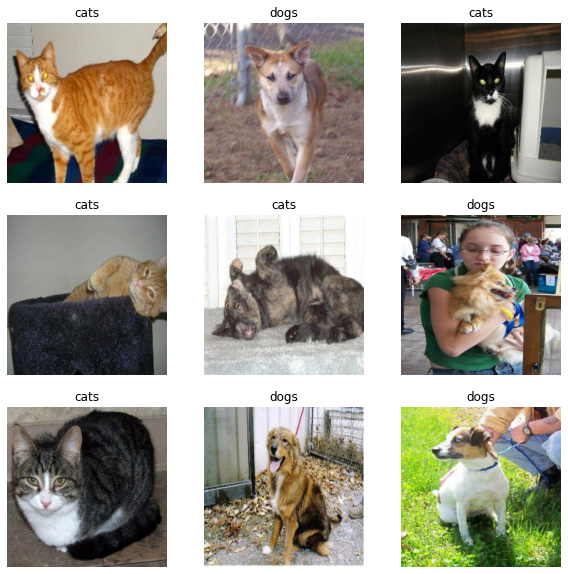

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in validation.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    #plt.imshow(images[i] / 2 + 0.5)
    #plt.imshow(images[i])
    plt.title(validation_class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

for image_batch, labels_batch in validation:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)
(32, 224, 224, 3)
(32,)


In [ ]:
def preprocess(image, label):
    #resized_image = tf.image.resize(image, [224, 224])
#    #final_image = keras.applications.xception.preprocess_input(resized_image)
    final_image = keras.applications.resnet50.preprocess_input(image)
    return final_image, label

def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]

def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    #resized_image = tf.image.resize(cropped_image, [224, 224])
    final_image = keras.applications.resnet50.preprocess_input(image)
    return final_image, label

display(train, validation)
train = train.unbatch()
validation = validation.unbatch()
display(train, validation)

AUTOTUNE = tf.data.AUTOTUNE

train_set = train.shuffle(100).repeat()
train_set = train.map(partial(preprocess, randomize=True)).batch(batch_size).cache().prefetch(buffer_size=AUTOTUNE)
#train_set = train.map(partial(preprocess)).batch(batch_size).prefetch(1)
validation_set = validation.map(preprocess).batch(batch_size).cache().prefetch(buffer_size=AUTOTUNE)

#train_image_batch, train_labels_batch = next(iter(train_set))
#validation_image_batch, validation_labels_batch = next(iter(validation_set))
#train_first_image = train_image_batch[0]
#validation_first_image = validation_image_batch[0]
## Notice the pixels values are now in `[0,1]`.
#display(np.min(train_first_image), np.max(train_first_image))
#display(np.min(validation_first_image), np.max(validation_first_image))

#normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255) #Rescaling(1./127.5, offset=-1)
#train_set = train_set.map(lambda x, y: (normalization_layer(x), y))
#validation_set = validation_set.map(lambda x, y: (normalization_layer(x), y))

train_image_batch, train_labels_batch = next(iter(train_set))
validation_image_batch, validation_labels_batch = next(iter(validation_set))
train_first_image = train_image_batch[0]
validation_first_image = validation_image_batch[0]
# Notice the pixels values are now in `[0,1]`.
display(np.min(train_first_image), np.max(train_first_image))
display(np.min(validation_first_image), np.max(validation_first_image))

display(train_set, validation_set)

<TakeDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>

<SkipDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>

<_UnbatchDataset shapes: ((224, 224, 3), ()), types: (tf.float32, tf.int32)>

<_UnbatchDataset shapes: ((224, 224, 3), ()), types: (tf.float32, tf.int32)>

-108.17949

97.87179

-123.68

151.061

<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>

<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>

In [ ]:
#display(train_set)
#display(validation_set)

#train_set = keras.applications.resnet50.preprocess_input(train.image_batch)
#validation_set = keras.applications.resnet50.preprocess_input(validation)

In [ ]:
base_model = keras.applications.resnet.ResNet101(weights="imagenet", include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(2, activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

In [ ]:
#for index, layer in enumerate(base_model.layers):
    #print(index, layer.name)

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
#AUTOTUNE = tf.data.AUTOTUNE
#display(AUTOTUNE)

#train_set = train_set.cache().prefetch(buffer_size=AUTOTUNE)
#train_set = train_set.cache().prefetch(1)
#validation_set = validation_set.cache().prefetch(buffer_size=AUTOTUNE)
#validation_set = validation_set.cache().prefetch(1)

In [ ]:
optimizer = keras.optimizers.SGD(learning_rate=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",          #optimizer=optimzer #optimizer="nadam"
              metrics=["accuracy"])
history = model.fit(train_set,
                    #steps_per_epoch=int(0.8 * 3000 / batch_size),
                    #steps_per_epoch=75,
                    validation_data=validation_set,
                    #validation_steps=int(0.2 * 3000 / batch_size),
                    #validation_steps=18,
                    epochs=5)

Epoch 1/5
75/75 [==============================] - 651s 9s/step - loss: 0.1851 - accuracy: 0.9214 - val_loss: 0.0407 - val_accuracy: 0.9899
Epoch 2/5
75/75 [==============================] - 639s 9s/step - loss: 0.0323 - accuracy: 0.9916 - val_loss: 0.0249 - val_accuracy: 0.9966
Epoch 3/5
75/75 [==============================] - 638s 9s/step - loss: 0.0191 - accuracy: 0.9967 - val_loss: 0.0191 - val_accuracy: 0.9966
Epoch 4/5
75/75 [==============================] - 638s 9s/step - loss: 0.0132 - accuracy: 0.9987 - val_loss: 0.0158 - val_accuracy: 0.9966
Epoch 5/5
75/75 [==============================] - 637s 9s/step - loss: 0.0097 - accuracy: 0.9992 - val_loss: 0.0139 - val_accuracy: 0.9983


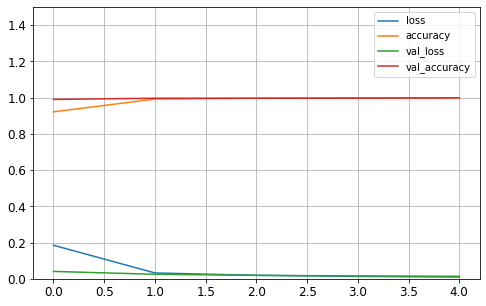

'Best accuracy: 0.998311'

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1.5)
plt.show()

val_accuracy = history.history['val_accuracy']
best_val_accuracy = max(val_accuracy)
display('Best accuracy: %f' % (best_val_accuracy))

In [ ]:
for layer in base_model.layers:
    layer.trainable = True

optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9,
                                 nesterov=True, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",       #optimizer=optimzer #optimizer="nadam"
              metrics=["accuracy"])
history = model.fit(train_set,
                    #steps_per_epoch=int(0.8 * 3000 / batch_size),
                    #steps_per_epoch=75,
                    validation_data=validation_set,
                    #validation_steps=int(0.2 * 3000 / batch_size),
                    #validation_steps=18,
                    epochs=40)

Epoch 1/40
     53/Unknown - 1617s 30s/step - loss: 0.9633 - accuracy: 0.6739

KeyboardInterrupt: ignored

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1.5)
plt.show()

In [ ]:
val_accuracy = history.history['val_accuracy']
best_val_accuracy = max(val_accuracy)
display('Best accuracy: %f' % (best_val_accuracy))

In [ ]:
def preprocess2(image, label):
    #resized_image = tf.image.resize(image, [224, 224])
#    #final_image = keras.applications.xception.preprocess_input(resized_image)
    final_image = keras.applications.mobilenet_v2.preprocess_input(image)
    return final_image, label

def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]

def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

def preprocess2(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    #resized_image = tf.image.resize(cropped_image, [224, 224])
    final_image = keras.applications.mobilenet_v2.preprocess_input(image)
    return final_image, label

data = data.shuffle(buffer_size=100)
train2 = data.take(76)
validation2 = data.skip(76)

train2 = train2.unbatch()
validation2 = validation2.unbatch()

train_set2 = train2.shuffle(100).repeat()
train_set2 = train2.map(partial(preprocess2, randomize=True)).batch(batch_size).cache().prefetch(buffer_size=AUTOTUNE)
#train_set2 = train2.map(partial(preprocess2)).batch(batch_size).prefetch(1)
validation_set2 = validation2.map(preprocess2).batch(batch_size).cache().prefetch(buffer_size=AUTOTUNE)

#train_image_batch, train_labels_batch = next(iter(train_set2))
#validation_image_batch, validation_labels_batch = next(iter(validation_set2))
#train_first_image = train_image_batch[0]
#validation_first_image = validation_image_batch[0]
# Notice the pixels values are now in `[0,1]`.
#display(np.min(train_first_image), np.max(train_first_image))
#display(np.min(validation_first_image), np.max(validation_first_image))

#normalization_layer2 = tf.keras.layers.experimental.preprocessing.Rescaling(1./255) #Rescaling(1./127.5, offset=-1)
#train_set2 = train_set2.map(lambda x, y: (normalization_layer2(x), y))
#validation_set2 = validation_set2.map(lambda x, y: (normalization_layer2(x), y))

train_image_batch, train_labels_batch = next(iter(train_set2))
validation_image_batch, validation_labels_batch = next(iter(validation_set2))
train_first_image = train_image_batch[0]
validation_first_image = validation_image_batch[0]
# Notice the pixels values are now in `[0,1]`.
display(np.min(train_first_image), np.max(train_first_image))
display(np.min(validation_first_image), np.max(validation_first_image))

display(train_set2, validation_set2)

base_model2 = keras.applications.mobilenet_v2.MobileNetV2(weights="imagenet", include_top=False)
avg2 = keras.layers.GlobalAveragePooling2D()(base_model2.output)
output2 = keras.layers.Dense(2, activation="softmax")(avg2)
model2 = keras.models.Model(inputs=base_model2.input, outputs=output2)

for layer in base_model2.layers:
    layer.trainable = False

optimizer2 = keras.optimizers.SGD(learning_rate=0.2, momentum=0.9, decay=0.01)
model2.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",        #optimizer=optimzer2 #optimizer="nadam"
              metrics=["accuracy"])
history2 = model2.fit(train_set2,
                    #steps_per_epoch=int(0.8 * 3000 / batch_size),
                    #steps_per_epoch=75,
                    validation_data=validation_set2,
                    #validation_steps=int(0.2 * 3000 / batch_size),
                    #validation_steps=18,
                    epochs=5)

pd.DataFrame(history2.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1.5)
plt.show()

val_accuracy2 = history2.history['val_accuracy']
best_val_accuracy2 = max(val_accuracy2)
display('Best accuracy: %f' % (best_val_accuracy2))

for layer in base_model2.layers:
    layer.trainable = True

optimizer2 = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9,
                                 nesterov=True, decay=0.001)
model2.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",            #optimizer=optimzer2 #optimizer="nadam"
              metrics=["accuracy"])
history2 = model2.fit(train_set2,
                    #steps_per_epoch=int(0.8 * 3000 / batch_size),
                    #steps_per_epoch=75,
                    validation_data=validation_set2,
                    #validation_steps=int(0.2 * 3000 / batch_size),
                    #validation_steps=18,
                    epochs=40)

pd.DataFrame(history2.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

val_accuracy2 = history2.history['val_accuracy']
best_val_accuracy2 = max(val_accuracy2)
display('Best accuracy: %f' % (best_val_accuracy2))

In [ ]:
img = tf.keras.preprocessing.image.load_img("dog.jpg")
input_arr = keras.preprocessing.image.img_to_array(img)
image = tf.image.resize(input_arr, [244,244])
input_arr = np.array([image])  # Convert single image to a batch.
prediction = model.predict(input_arr)
prediction2 = model2.predict(input_arr)
display(prediction, prediction2)
#['cats', 'dogs']

If everything I did was correct, then ResNet101 took longer but was more accurate (and gave a correct prediction). MobileNetV2 was quicker but less accurate (and gave an incorrect prediction).